## Como construir un  Chatbot Multi-modal RAG

Muchos documentos contienen una mezcla de tipos de contenido, incluidos texto e imágenes.
Sin embargo, la información capturada en las imágenes se pierde en la mayoría de las aplicaciones RAG.
Con la aparición de modelos de lenguaje multimodal, como GPT-4V, ¿Vale la pena considerar cómo utilizar las imágenes en RAG?

`¿Qué haremos hoy?`

* Usar un modelo de lemguaje multimodal ([GPT-4V](https://openai.com/research/gpt-4v-system-card),  para generar resumenes de images.
* Recuperar y embeber esos resumenes con una referencia al archivo original.
* Recuperar contenido original y respuesta a una pregunta realizada.


`¿Qué tecnologías se usarán?`

* Usaremos [Unstructured](https://unstructured.io/) para analizar imágenes, texto y tablas de documentos (PDFs).
* Utilizaremos el [multi-vector retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector) con [Chroma](https://www.trychroma.com/) para almacenar el texto e imágenes junto con sus resúmenes para su posterior recuperación.
* Usaremos GPT-4V/GPT-4o tanto para la generación de resúmenes de imágenes (para su recuperación) como para la síntesis final de respuestas a partir del análisis conjunto de imágenes y textos (o tablas).


`Antes de empezar`

Además de los paquetes pip mencionados a continuación, también necesitarás instalar `poppler` ([instrucciones de instalación](https://pdf2image.readthedocs.io/en/latest/installation.html)) y `tesseract` ([instrucciones de instalación](https://tesseract-ocr.github.io/tessdoc/Installation.html)) en tu sistema.


In [4]:
! pip install langchain langchain-community langchain-core langchain-text-splitters openai langchain-chroma langchain-experimental langchain-openai load_dotenv chromadb


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Data Loading

### Partition PDF tables, text, and images

Luego de saltarnos la extracción por unestructured.

[Aquí](https://drive.google.com/file/d/1QlhGFIFwEkNEjQGOvV_hQe4bnOLDJwCR/view?usp=sharing) tienes un archivo zip con un subconjunto de las imágenes y el PDF extraídos.

Si deseas utilizar la carpeta proporcionada, simplemente opta por un [pdf loader](https://python.langchain.com/docs/modules/data_connection/document_loaders/pdf) para el documento:

```python
from langchain_community.document_loaders import PyPDFLoader
loader = PyPDFLoader(path + fname)
docs = loader.load()
tables = [] # Ignorar con el cargador básico de PDF
texts = [d.page_content for d in docs]
```

In [36]:
from langchain.text_splitter import CharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader

# load elements from PDF
def load_pdf_elements(path):
    """
    Extract images, tables, and chunk text from a PDF file.
    path: File path, which is used to dump images (.jpg)
    fname: File name
    """
    # Get elements

    loader = PyPDFLoader(path + fname)
    docs = loader.load()
    tables = [] # Ignore w/ basic pdf loader
    texts = [d.page_content for d in docs]


    # Chunking transformation
    text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
        chunk_size=4000, chunk_overlap=0
    )
    joined_texts = " ".join(texts)
    return text_splitter.split_text(joined_texts), texts


texts_4k_token, texts = load_pdf_elements(fpath)
print(texts)
print(texts_4k_token)

['11/14/23, 8:35 PM Clouded Judgement 11.10.23 - by Jamin Ball\nhttps://cloudedjudgement.substack.com/p/clouded-judgement-111023 1/21Clouded Judgement 11.10.23 - OpenAI\nUpdates + Datadog Gives the All-Clear?\nJAMIN BALL\nNOV 10, 2023\n2 Share\nEvery week I’ll provide updates on the latest trends in cloud so\x00ware companies. Follow along to\nstay up to date!\nOpen AI U pdates\nOpenAI had their big developer day this week, and I wanted to call out two key announcements\n(and trends): increasing context windows and decreasing costs.\nWhen I think about the monetization of AI (and which “layers” monetize \x00rst) I’ve always\nthought it would follow the below order, with each layer lagging the one that comes before it.\n1. Raw silicon (chips like Nvidia bought in large quantities to build out infra to service\nupcoming demand).\n2. Model providers (OpenAI, Anthropic, etc as companies start building out AI).\n35\nType your email... Subscribe', '11/14/23, 8:35 PM Clouded Judgement 11.10.2

## Recuperador multi-vectorial

Utiliza [recuperador multi-vectorial](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector#summary) para indexar resúmenes de imágenes (y / o texto, tablas), pero recupera imágenes originales (junto con textos o tablas originales).

### Resúmenes de texto y tabla

Usaremos GPT-4o para producir resúmenes de tablas y, opcionalmente, de texto.

Se recomienda utilizar resúmenes de texto si se usan tamaños de fragmentos grandes (por ejemplo, como se establece arriba, usamos fragmentos de 4k tokens).

Los resúmenes se utilizan para recuperar tablas originales y / o fragmentos originales de texto.


In [37]:
import os
from dotenv import load_dotenv
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

load_dotenv()

tables = []

# Generate summaries of text elements
def generate_text_summaries(texts, summarize_texts=False):
    """
    Summarize text elements
    texts: List of str
    tables: List of str
    summarize_texts: Bool to summarize texts
    """

    # Prompt
    prompt_text = """You are an assistant tasked with summarizing tables and text for retrieval. \
    These summaries will be embedded and used to retrieve the raw text or table elements. \
    Give a concise summary of the table or text that is well optimized for retrieval. Table or text: {element} """
    prompt = ChatPromptTemplate.from_template(prompt_text)

    # Text summary chain
    model = ChatOpenAI(temperature=0, model="gpt-4o", api_key= os.environ.get("OPENAI_API_KEY"))
    summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

    # Initialize empty summaries
    text_summaries = []
    table_summaries = []

    # Apply to text if texts are provided and summarization is requested
    if texts and summarize_texts:
        text_summaries = summarize_chain.batch(texts, {"max_concurrency": 5})
    elif texts:
        text_summaries = texts

    # Apply to tables if tables are provided
    # if tables:
    #   table_summaries = summarize_chain.batch(tables, {"max_concurrency": 5})

    return text_summaries, table_summaries


# Get text, table summaries
text_summaries, table_summaries = generate_text_summaries(
    texts_4k_token, summarize_texts=True
)


print("text_summaries", text_summaries )
print("texts", texts )

text_summaries ['The article "Clouded Judgement 11.10.23" by Jamin Ball discusses recent developments in the cloud software industry, focusing on OpenAI and Datadog. OpenAI\'s key announcements include expanding context windows for GPT-4 Turbo from 8k to 128k tokens and reducing costs, making AI experimentation more accessible. The article outlines the monetization layers of AI, highlighting challenges in scalable monetization due to high costs. Datadog\'s positive quarterly earnings report led to a significant stock increase, suggesting an improving macro environment for software companies. The article also provides insights into SaaS valuation metrics, emphasizing revenue multiples and growth rates.']
texts ['11/14/23, 8:35 PM Clouded Judgement 11.10.23 - by Jamin Ball\nhttps://cloudedjudgement.substack.com/p/clouded-judgement-111023 1/21Clouded Judgement 11.10.23 - OpenAI\nUpdates + Datadog Gives the All-Clear?\nJAMIN BALL\nNOV 10, 2023\n2 Share\nEvery week I’ll provide updates on t

### Image summaries 

Usaremos [GPT-4V](https://openai.com/research/gpt-4v-system-card) para producir los resúmenes de imágenes.

La documentación de la API [aquí](https://platform.openai.com/docs/guides/vision):

* Pasamos imágenes codificadas en base64.


In [33]:
import base64
import os

from langchain_core.messages import HumanMessage


def encode_image(image_path):
    """Getting the base64 string"""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


def image_summarize(img_base64, prompt):
    """Make image summary"""
    chat = ChatOpenAI(model="gpt-4-vision-preview", max_tokens=1024)

    msg = chat.invoke(
        [
            HumanMessage(
                content=[
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"},
                    },
                ]
            )
        ]
    )
    return msg.content


def generate_img_summaries(path):
    """
    Generate summaries and base64 encoded strings for images
    path: Path to list of .jpg files extracted by Unstructured
    """

    # Store base64 encoded images
    img_base64_list = []

    # Store image summaries
    image_summaries = []

    # Prompt
    prompt = """You are an assistant tasked with summarizing images for retrieval. \
    These summaries will be embedded and used to retrieve the raw image. \
    Give a concise summary of the image that is well optimized for retrieval."""

    # Apply to images
    print(path)
    for img_file in sorted(os.listdir(path)):
        if img_file.endswith(".jpg"):
            img_path = os.path.join(path, img_file)
            base64_image = encode_image(img_path)
            img_base64_list.append(base64_image)
            image_summaries.append(image_summarize(base64_image, prompt))

    return img_base64_list, image_summaries


# Image summaries

path_images = "figures/"
img_base64_list, image_summaries = generate_img_summaries(path_images)

print("image_summaries", image_summaries )

figures/
image_summaries ['This image depicts a line graph titled "EV / NTM Revenue Multiples," tracking the enterprise value to next twelve months (NTM) revenue multiples over time. The x-axis represents time from January 2015 to October 2023, and the y-axis shows the revenue multiple values ranging from 0.0x to 45.0x. There are three lines representing High Growth Median (blue), Mid Growth Median (red), and Low Growth Median (orange), each showing different trends and volatility levels. The blue line exhibits a significant peak surpassing 40.0x before a sharp decline to around 11.8x, the red line peaks around 15.0x and falls to about 7.4x, and the orange line remains relatively stable under 10.0x, concluding near 3.9x. The source of the graph is attributed to Altimeter, and a Twitter handle "@jaminball" is labelled "Clouded Judgement."', 'Horizontal bar chart displaying the Enterprise Value to Next Twelve Months (EV/NTM) Revenue multiples for various companies. The chart includes a m

### Agregar al vectorstore

Agrega documentos originales y resúmenes de documentos al [Recuperador Multi Vectorial](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector#summary): 

* Almacena los textos, tablas e imágenes originales en el `docstore`.
* Almacena los textos, resúmenes de tablas y resúmenes de imágenes en el `vectorstore` para una recuperación semántica eficiente.

In [39]:
import uuid

from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore
from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings


def create_multi_vector_retriever(
    vectorstore, text_summaries, texts, table_summaries, tables, image_summaries, images
):
    """
    Create retriever that indexes summaries, but returns raw images or texts
    """

    # Initialize the storage layer
    store = InMemoryStore()
    id_key = "doc_id"

    # Create the multi-vector retriever
    retriever = MultiVectorRetriever(
        vectorstore=vectorstore,
        docstore=store,
        id_key=id_key,
    )


    # Helper function to add documents to the vectorstore and docstore
    def add_documents(retriever, doc_summaries, doc_contents):
        doc_ids = [str(uuid.uuid4()) for _ in doc_contents]
        summary_docs = [
            Document(page_content=s, metadata={id_key: doc_ids[i]})
            for i, s in enumerate(doc_summaries)
        ]
        retriever.vectorstore.add_documents(summary_docs)
        retriever.docstore.mset(list(zip(doc_ids, doc_contents)))

    # Add texts, tables, and images
    # Check that text_summaries is not empty before adding
    if text_summaries:
        add_documents(retriever, text_summaries, texts)
    # Check that table_summaries is not empty before adding
    #if table_summaries:
    #    add_documents(retriever, table_summaries, tables)
    # Check that image_summaries is not empty before adding
    if image_summaries:
        add_documents(retriever, image_summaries, images)

    return retriever


# The vectorstore to use to index the summaries
vectorstore = Chroma(
    collection_name="mm_rag_demo", embedding_function=OpenAIEmbeddings()
)

# Create retriever
retriever_multi_vector_img = create_multi_vector_retriever(
    vectorstore,
    text_summaries,
    texts,
    table_summaries,
    tables,
    image_summaries,
    img_base64_list,
)

## RAG

### Construir un retrieval

Necesitamos organizar el/los documento(s) recuperado(s) y pasarlas al modelo


In [40]:
import io
import re
import base64  # Import base64 for encoding and decoding images

from IPython.display import HTML, display
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from PIL import Image


def plt_img_base64(img_base64):
    """Display base64 encoded string as image"""
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    # Display the image by rendering the HTML
    display(HTML(image_html))


def looks_like_base64(sb):
    """Check if the string looks like base64"""
    # Use regex to determine if the string is in base64 format
    return re.match("^[A-Za-z0-9+/]+[=]{0,2}$", sb) is not None


def is_image_data(b64data):
    """
    Check if the base64 data is an image by looking at the start of the data
    """
    image_signatures = {
        b"\xff\xd8\xff": "jpg",
        b"\x89\x50\x4e\x47\x0d\x0a\x1a\x0a": "png",
        b"\x47\x49\x46\x38": "gif",
        b"\x52\x49\x46\x46": "webp",
    }
    try:
        header = base64.b64decode(b64data)[:8]  # Decode and get the first 8 bytes
        for sig, format in image_signatures.items():
            if header.startswith(sig):
                return True  # Return True if the signature matches
        return False  # Return False if no matches found
    except Exception:
        return False  # Return False if there's an error during processing


def resize_base64_image(base64_string, size=(128, 128)):
    """
    Resize an image encoded as a Base64 string
    """
    # Decode the Base64 string
    img_data = base64.b64decode(base64_string)
    img = Image.open(io.BytesIO(img_data))  # Open the image from bytes

    # Resize the image
    resized_img = img.resize(size, Image.LANCZOS)

    # Save the resized image to a bytes buffer
    buffered = io.BytesIO()
    resized_img.save(buffered, format=img.format)

    # Encode the resized image to Base64
    return base64.b64encode(buffered.getvalue()).decode("utf-8")


def split_image_text_types(docs):
    """
    Split base64-encoded images and texts
    """
    b64_images = []
    texts = []
    for doc in docs:
        # Check if the document is of type Document and extract page_content if so
        if isinstance(doc, Document):
            doc = doc.page_content
        if looks_like_base64(doc) and is_image_data(doc):
            doc = resize_base64_image(doc, size=(1300, 600))  # Resize valid images
            b64_images.append(doc)  # Append resized image to list
        else:
            texts.append(doc)  # Append text content to list
    return {"images": b64_images, "texts": texts}  # Return dictionary of images and texts


def img_prompt_func(data_dict):
    """
    Join the context into a single string
    """
    formatted_texts = "\n".join(data_dict["context"]["texts"])  # Format texts into a single string
    messages = []

    # Adding image(s) to the messages if present
    if data_dict["context"]["images"]:
        for image in data_dict["context"]["images"]:
            image_message = {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{image}"},
            }
            messages.append(image_message)  # Append image message to list

    # Adding the text for analysis
    text_message = {
        "type": "text",
        "text": (
            "You are financial analyst tasking with providing investment advice.\n"
            "You will be given a mixed of text, tables, and image(s) usually of charts or graphs.\n"
            "Use this information to provide investment advice related to the user question. \n"
            f"User-provided question: {data_dict['question']}\n\n"
            "Text and / or tables:\n"
            f"{formatted_texts}"
        ),
    }
    messages.append(text_message)  # Append text message to list
    return [HumanMessage(content=messages)]  # Return list of messages as HumanMessage


def multi_modal_rag_chain(retriever):
    """
    Multi-modal RAG chain
    """

    # Multi-modal LLM
    model = ChatOpenAI(temperature=0, model="gpt-4-vision-preview", max_tokens=1024)

    # RAG pipeline
    chain = (
        {
            "context": retriever | RunnableLambda(split_image_text_types),  # Create context with retriever and image/text splitter
            "question": RunnablePassthrough(),
        }
        | RunnableLambda(img_prompt_func)  # Process input through the image prompt function
        | model  # Pass the processed input to the model
        | StrOutputParser()  # Parse the model's output to a string format
    )

    return chain  # Return the constructed chain


# Create RAG chain
chain_multimodal_rag = multi_modal_rag_chain(retriever_multi_vector_img)  # Initialize multi-modal RAG chain


### Check

Examina el retrieval; obtenemos imágenes que son relevantes para nuestra pregunta.

In [41]:
# Check retrieval
query = "Give me company names that are interesting investments based on EV / NTM and NTM rev growth. Consider EV / NTM multiples vs historical?"
docs = retriever_multi_vector_img.invoke(query, limit=6)

# We get 4 docs
len(docs)

4


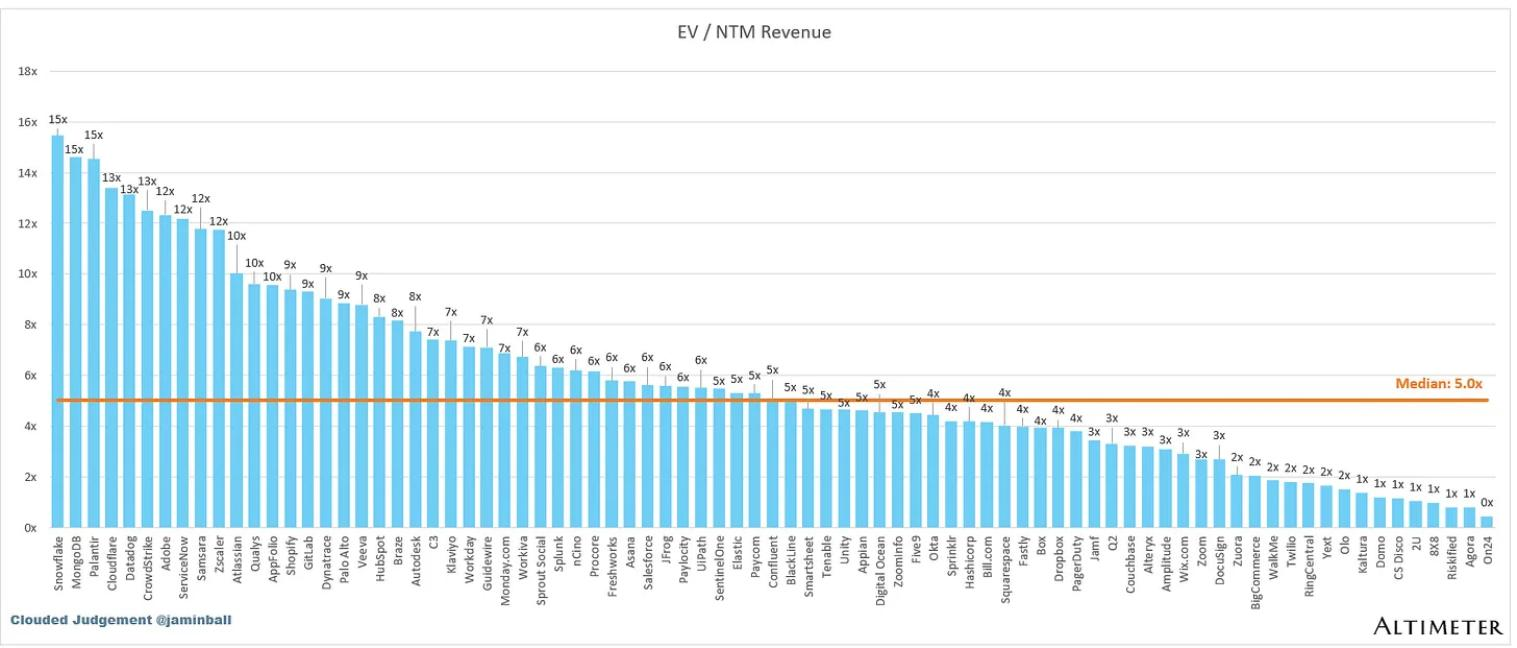

In [42]:
# We get back relevant images
plt_img_base64(docs[0])

In [43]:
image_summaries[3]

"Horizontal bar chart showing growth-adjusted enterprise value to next twelve months' revenue (EV/NTM Revenue/EV/NTM Growth) for various companies, with values ranging from 1.7x to 0.1x. The median value is indicated at 0.4x. The chart is attributed to Clouded Judgement @jamingball and includes the Altimeter logo."

### Q&A - RAG

Ahora ejecutemos RAG y probemos la capacidad de sintetizar una respuesta a nuestra pregunta.


In [44]:
chain_multimodal_rag.invoke(query)

"Based on the information provided in the images, we can analyze potential investment opportunities by looking at the Enterprise Value to Next Twelve Months (EV/NTM) revenue multiples and the NTM revenue growth rates. Here's how we can interpret the data:\n\n1. **EV/NTM Revenue Multiples**: The first image shows a bar chart with various companies and their respective EV/NTM revenue multiples. The median value is indicated as 5.0x. Companies with multiples significantly higher than the median might be considered overvalued, while those below could be undervalued or reflect lower growth expectations.\n\n2. **Historical EV/NTM Revenue Multiples**: The second image provides a historical perspective on EV/NTM revenue multiples for high, mid, and low growth companies. It's important to compare the current multiples with historical trends to understand if the multiples are above or below the historical average, which could indicate overvaluation or undervaluation.\n\n3. **Growth-Adjusted EV/N

### Consideraciones para un Chatbot RAG con PDFs, Imágenes y Tablas

`Consideraciones Técnicas`
- **Formato de Datos**: Asegúrate de que los PDFs, imágenes y tablas sean procesables y contengan texto extraíble.
- **Extracción de Contenido**: Utiliza herramientas de OCR para PDFs y métodos adecuados para tablas e imágenes.

`Consideraciones de Usuario`
- **Experiencia del Usuario**: Diseña una interfaz intuitiva para la interacción con diferentes tipos de contenido.
- **Feedback del Usuario**: Implementa mecanismos para recoger opiniones sobre la relevancia de las respuestas.

`Consideraciones de Seguridad`
- **Protección de Datos**: Maneja datos sensibles conforme a regulaciones de privacidad.
- **Control de Acceso**: Asegura que solo usuarios autorizados accedan a información confidencial.

`Consideraciones de Rendimiento`
- **Velocidad de Respuesta**: Optimiza el sistema para tiempos de respuesta rápidos.
- **Escalabilidad**: Diseña para manejar un aumento en el volumen de datos y solicitudes.

`Consideraciones de Mantenimiento`
- **Actualización de Contenido**: Establece un proceso para mantener la información actualizada.
- **Monitoreo**: Utiliza herramientas de análisis para mejorar el rendimiento del chatbot.
